In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import pyblock
from scipy.special import logsumexp
from scipy.special import softmax

# matplotlib settings
# --- Publication style settings ---
plt.rcParams.update({
    # Font
    "font.family": "Times New Roman",
    "font.serif": ["Arial"],  # or other preferred serif font
    "mathtext.fontset": "cm",            # Computer Modern for math text
    "text.usetex": False,                 # Use LaTeX for text rendering]
    "pdf.fonttype": 42,                 # Use LaTeX for text rendering

    # Figure
    "figure.figsize": (6, 4),            # width, height in inches
    "figure.dpi": 300,                   # high resolution

    # Axes
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "axes.linewidth": 1.2,
    "axes.grid": True,                   # optional, remove if you want no grid
    "grid.linestyle": "--",
    "grid.alpha": 0.7,

    # Ticks
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.top": True,
    "ytick.right": True,

    # Lines
    "lines.linewidth": 2,
    "lines.markersize": 6,

    # Legend
    "legend.fontsize": 10,
    "legend.frameon": False
})

# functions
# read_colvar function which sorts colvar for unique entries from the back (i.e., second entry retained)
def read_colvar(colvar_file):

    data = np.loadtxt(colvar_file)
    # inverse order
    data = data[::-1]
    unique_idxs = np.array(np.unique(data[:,0], return_index=True)[1]).astype(int)[::-1] # find unique indices, first occurences
    data = data[unique_idxs]
    # original order
    data = data[::-1]

    return data


output_path = '../Ensemble_reweighting/ACTR_OPES_310K_ensemble/'
prod_name = '300K'
path = '../OPES_multiT/ACTR/NEW_PRODUCTION_300K_2fs_80steps/alldata/'

In [2]:
# weights & frames at 310 K (experimental conditions)

kb=0.008314
T0 = 300
T=310
kbt = kb*T0
nsims = 5


# load data and concatenate
for sim in range(nsims):
    if sim==0:
        data = read_colvar(path+f'COLVAR.{sim}')
        CVS = np.loadtxt(path+f'CVS_DATA.{sim}')
        hydroph = np.loadtxt(path+f'HYDROPH.{sim}')
        # Time arrays in μs
        time_data = data[:, 0] / 1e6        # ps -> μs
        # Apply cutoff at 5 µs
        mask_data = time_data <= 5.0 
        data = data[mask_data]
        CVS = CVS[mask_data]
        hydroph = hydroph[mask_data]
        frames = np.arange(CVS.shape[0])
    else:
        tmpdata = read_colvar(path+f'COLVAR.{sim}')
        tmpCVS = np.loadtxt(path+f'CVS_DATA.{sim}')
        tmphydroph = np.loadtxt(path+f'HYDROPH.{sim}')
        # Time arrays in μs
        time_data = tmpdata[:, 0] / 1e6        # ps -> μs
        # Apply cutoff at 5 µs
        mask_data = time_data <= 5.0 
        tmpdata = tmpdata[mask_data]
        tmpCVS = tmpCVS[mask_data]
        tmphydroph = tmphydroph[mask_data]
        tmpframes = np.arange(tmpCVS.shape[0])
        data = np.concatenate((data, tmpdata), axis=0)
        CVS = np.concatenate((CVS, tmpCVS), axis=0)
        hydroph = np.concatenate((hydroph, tmphydroph), axis=0)
        frames = np.concatenate((frames, tmpframes), axis=0)

# downsample
data = data[::2]
CVS = CVS[::2]
hydroph = hydroph[::2]
frames = frames[::2]
print(np.min(frames))

# analysis of concatenated data
bias = data[:,2]
ene = data[:,1] # U
logw = (bias + (1 - T0 / T) * ene) / (kb * T0)
w = softmax(logw)
w = w/np.sum(w)
# remove frames with w=0
mask = w != 0
#mask = w>1e-30
mask = w>1e-10
print(np.sum(w[mask]))
weights_clean = w[mask]
weights_clean = weights_clean/np.sum(weights_clean)
rgdata = CVS[:,1][mask]
alpha = CVS[:,2][mask]
hydrophobic_contacts = hydroph[:,1][mask]
frames = frames[mask]
print(np.average(rgdata, axis=0, weights=weights_clean))
print(np.average(alpha, axis=0, weights=weights_clean))
print(np.average(hydrophobic_contacts, axis=0, weights=weights_clean))
weights_clean.shape
        
    

0
0.9999997537606269
1.8900691090183266
5.336111132107953
9.33915645169446


(61008,)

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


6
499988
(61008,)


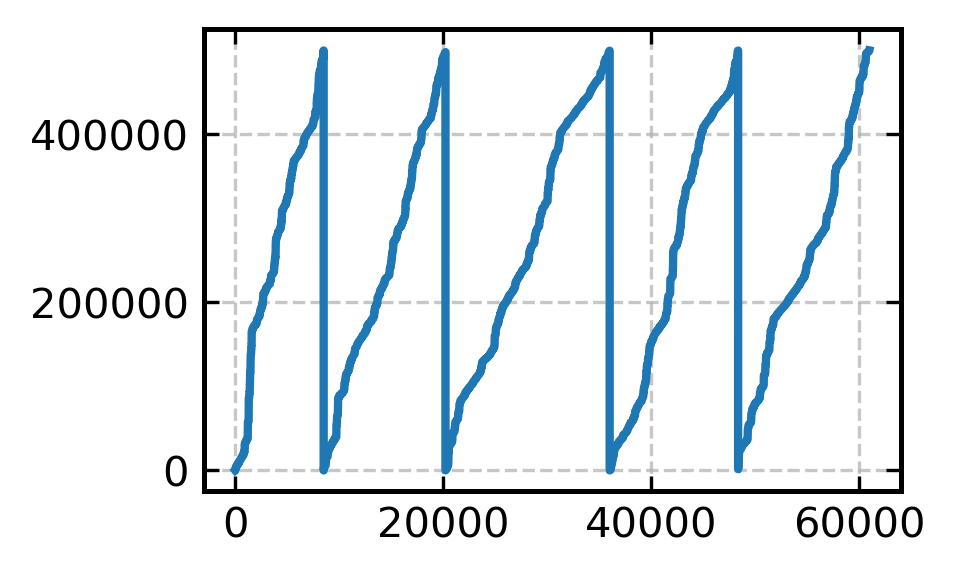

In [3]:
print(np.min(frames))
print(np.max(frames))
print(frames.shape)
plt.figure(figsize = (3, 2))
plt.plot(frames)
plt.show()

In [5]:
print(np.sum(weights_clean))
np.savetxt(output_path+"weights_310K.txt", weights_clean)


1.0


In [6]:
# calculate ESS
(weights_clean.sum()**2) / (np.sum(weights_clean**2))

21141.258157453376

In [7]:
def split_on_drop(arr):
    arr = np.asarray(arr)
    # find where index drops
    drop_points = np.where(arr[1:] < arr[:-1])[0] + 1
    
    # split array at drop points
    parts = np.split(arr, drop_points)
    return parts

# split indices
split_frames = split_on_drop(frames)
for idx, sframes in enumerate(split_frames):
    with open(output_path+f'frames_310K_{idx}.ndx', 'w') as f:
        f.write('[ frames ]\n')
        for ele in sframes:
            f.write(f'{int(ele+1)}\n') # +1 because gromacs frames index starts at 1

            

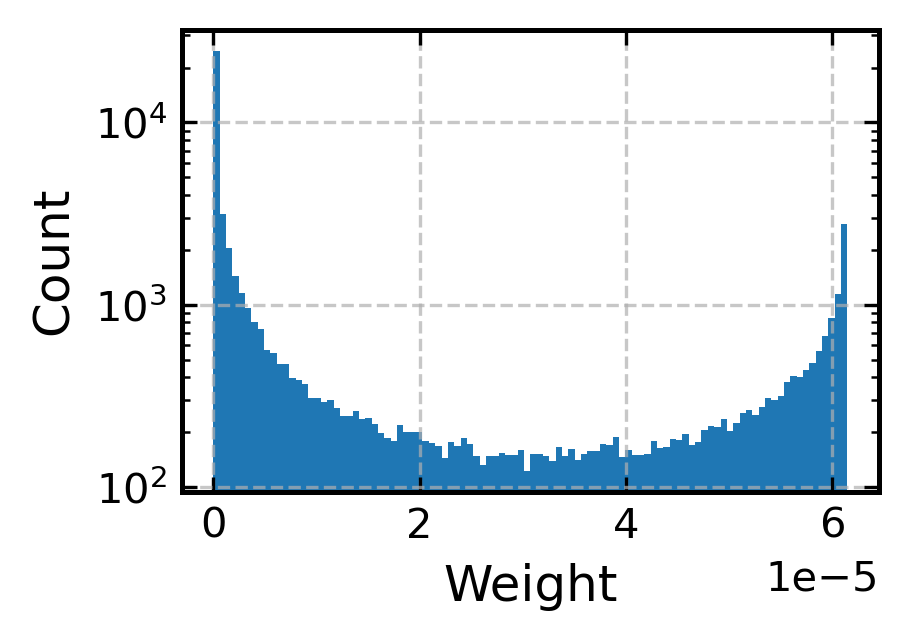

In [27]:
plt.figure(figsize = (3, 2))
plt.hist(weights_clean, bins=100)
plt.yscale('log')
plt.xlabel('Weight')
plt.ylabel('Count')
plt.show()

In [8]:
# save descriptors
np.savetxt(output_path+f"rg_opes_310K.txt", rgdata)
np.savetxt(output_path+f"alpharmsd_opes_310K.txt", alpha)
np.savetxt(output_path+f"hydroph_contacts_opes_310K.txt", hydrophobic_contacts)
